# Navnet R&D Notebook

## Prepare dataset

In [1]:
training_dataset_root_path = "/home/michael/Desktop/BytesDB_train/"
validation_dataset_root_path = "/home/michael/Desktop/BytesDB_valid/"

In [2]:
import csv
import os

class BytesDataset:
    def __init__(self,  root_path):
        self.root_path = root_path
        self.dataset_left_imgs = os.path.join(self.root_path, "left")
        self.dataset_right_imgs = os.path.join(self.root_path, "right")
        self.dataset_file = os.path.join(self.root_path, "db.csv")
        self._read_db_file()
        
    def get_index_map(self):
        return self.index_map
    
    def get_left_images_path(self):
        return self.dataset_left_imgs 
    
    def get_right_images_path(self):
        return self.dataset_right_imgs 
    
    def get_db(self):
        return self.db_file
    
    def get_episode_indices(self):
        return self.episode_indicies
    
    def get_position(self, row):
        return [self.get_db_value(row, 'position x'), self.get_db_value(row, 'position y'), self.get_db_value(row, 'position z')]
    
    def get_orientation(self, row):
        return [self.get_db_value(row, 'odom orientation z'), self.get_db_value(row, 'odom orientation y'), self.get_db_value(row, 'odom orientation x'), self.get_db_value(row, 'odom orientation w')]
    
    def get_db_value(self, row, column):
        if type(column) == str:
            column = self.index_map[column]
        if column:
            return float(self.db_file[row][column])
        else: 
            return self.db_file[row][column]
    
    def _read_db_file(self):
        # Read the db file
        self.db_file = []
        # start and stops for each episode (zero to be replaced later) [inclusive, exclusive]
        self.episode_indicies = [[1,0]] 
        with open(self.dataset_file) as file:
            csv_reader = csv.reader(file)
            for i, row in enumerate(csv_reader):
                if(row[0] == "-"):
                    self.episode_indicies.append([i+1,0])
                    self.episode_indicies[len(self.episode_indicies)-2][1] = i
                self.db_file.append(row)
            if self.episode_indicies[len(self.episode_indicies)-1][1] == 0:
                self.episode_indicies[len(self.episode_indicies)-1][1] = len(self.db_file)
        self.index_map = dict(zip(self.db_file[0],range(len(self.db_file[0]))))
        
validation_data = BytesDataset(validation_dataset_root_path)
train_data = BytesDataset(training_dataset_root_path) 

print("Size of training set: ", len(train_data.get_db()))
print("Size of validation set: ", len(validation_data.get_db()))

Size of training set:  76453
Size of validation set:  3375


In [3]:
print(validation_data.episode_indicies)

[[1, 104], [105, 152], [153, 171], [172, 212], [213, 264], [265, 516], [517, 538], [539, 656], [657, 680], [681, 852], [853, 957], [958, 1092], [1093, 1211], [1212, 1267], [1268, 1446], [1447, 1539], [1540, 1665], [1666, 1938], [1939, 2096], [2097, 2125], [2126, 2133], [2134, 2288], [2289, 2443], [2444, 2639], [2640, 2763], [2764, 2791], [2792, 2915], [2916, 3106], [3107, 3196], [3197, 3375]]


### Add functions for reading / augmenting images

In [4]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return torch.clamp(tensor + torch.randn(tensor.size()) * self.std + self.mean, min=0, max=1.0)
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [5]:
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torchvision
import torchvision.transforms as transforms

def process_image(img, augment=False):
    if augment:
        transform = transforms.Compose(
        [transforms.ColorJitter(0.5, 0.5, 0.5),
         transforms.RandomAffine(10, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
         transforms.ToTensor(),
         AddGaussianNoise(0, 0.01),
         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # imagenet normalization
        ]) 
    else: 
        transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # imagenet normalization
        ]) 
    img = transform(Image.fromarray(img))
    return img 

def read_image(time_stamp, imgs_path, augment=False):
    img = plt.imread(os.path.join(imgs_path, time_stamp + ".jpg"))
    return process_image(img, augment)

image = read_image(train_data.get_db()[2][0], train_data.get_left_images_path())

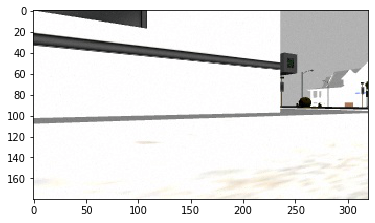

In [6]:
import numpy as np

def show_tensor_img(image):
    npimg = image.numpy().copy()
    # unnormalize the image
    npimg[0] *= 0.229
    npimg[1] *= 0.224
    npimg[2] *= 0.225
    npimg[0] += 0.485
    npimg[1] += 0.456
    npimg[2] += 0.406
    npimg = np.transpose(npimg, (1,2,0))
    return npimg

plt.imshow(show_tensor_img(image))

### Add functions for generating batches

In [7]:
def quaternion_mult(q,r):
    return [r[0]*q[0]-r[1]*q[1]-r[2]*q[2]-r[3]*q[3],
            r[0]*q[1]+r[1]*q[0]-r[2]*q[3]+r[3]*q[2],
            r[0]*q[2]+r[1]*q[3]+r[2]*q[0]-r[3]*q[1],
            r[0]*q[3]-r[1]*q[2]+r[2]*q[1]+r[3]*q[0]]

# input point is [x,y,z] and quaternion is z, x, y, w
def point_rotation_by_quaternion(point,q):
    r = [0]+point
    q_conj = [q[0],-1*q[1],-1*q[2],-1*q[3]]
    return quaternion_mult(quaternion_mult(q,r),q_conj)[1:]

# point 1 - point 2
def subtract_points(point1, point2):
    return [point1[0] - point2[0], point1[1] - point2[1], point1[2] - point2[2]]

In [138]:
import random

def batch_generator(dataset, image_shape=(3,180,320), collision_buffering=3, timesteps=10, batch_size=16, augmentation=False):
    
    while True:
        
        left_images = torch.zeros((batch_size, image_shape[0], image_shape[1], image_shape[2]))
        right_images = torch.zeros((batch_size, image_shape[0], image_shape[1], image_shape[2]))
        actions = torch.zeros((batch_size, timesteps, 2))
        labels = torch.zeros((batch_size, timesteps, 4))
        
        for i in range(batch_size):
            
            start = -1
            episode_num = -1
            while(start < 1):
                try:
                    episode_num = random.randint(0, len(dataset.get_episode_indices())-1)
                    start = random.randint(dataset.get_episode_indices()[episode_num][0], dataset.get_episode_indices()[episode_num][1]-timesteps-1)
                except:
                    pass
           
            # now that we have a starting index we can build oup the output sequence
            image_name = dataset.get_db()[start][0] if '.' in dataset.get_db()[start][0] else dataset.get_db()[start][0] + "."
            left_images[i]  = read_image(image_name, dataset.get_left_images_path(), augmentation)
            right_images[i] = read_image(image_name, dataset.get_right_images_path(), augmentation)
            
            starting_position = dataset.get_position(start)
            starting_orientation = dataset.get_orientation(start)
            
            episode_actions = []
            episode_labels = []
            for t in range(timesteps):
                # convert position into robots first action reference space
                new_position = dataset.get_position(start+t)
                transformed_point = point_rotation_by_quaternion(subtract_points(starting_position, new_position), starting_orientation)
                
#                 print(start+t)
    
                episode_actions.append([dataset.get_db_value(start+t, 'action x')*2-1,dataset.get_db_value(start+t, 'action r')]) # normalize x
        
                # look ahead for the collision buffer
                collision = dataset.get_db_value(start+t,'collision bool')
                c = 1
                while c < collision_buffering+1 and start+t+c < dataset.get_episode_indices()[episode_num][1]:
                    if dataset.get_db_value(start+t+c,'collision bool') == True:
                        collision = True
                    c += 1
                    

                episode_labels.append([-transformed_point[1], transformed_point[0], dataset.get_db_value(start+t, 'bumpiness score'), collision])

            actions[i] = torch.tensor(episode_actions)
            labels[i] = torch.tensor(episode_labels)
        
        yield (left_images, right_images, actions, labels)            

In [139]:
gen = batch_generator(train_data)
left_images, right_images, actions, labels = next(gen)

print(actions[5])
print(labels[5, :, :2])

tensor([[-0.0930,  0.2686],
        [-0.0795,  0.2689],
        [-0.0042,  0.1688],
        [-0.0799, -0.0289],
        [ 0.0588, -0.1888],
        [ 0.0237, -0.2335],
        [-0.1396, -0.0255],
        [-0.2570,  0.1333],
        [-0.2632,  0.1529],
        [-0.1989, -0.0137]])
tensor([[-0.0000,  0.0000],
        [-0.0080,  0.1720],
        [-0.0217,  0.2870],
        [-0.0360,  0.3817],
        [-0.0601,  0.5931],
        [-0.0646,  0.6797],
        [-0.0684,  0.9284],
        [-0.0695,  0.9775],
        [-0.0771,  1.1160],
        [-0.0843,  1.1962]])


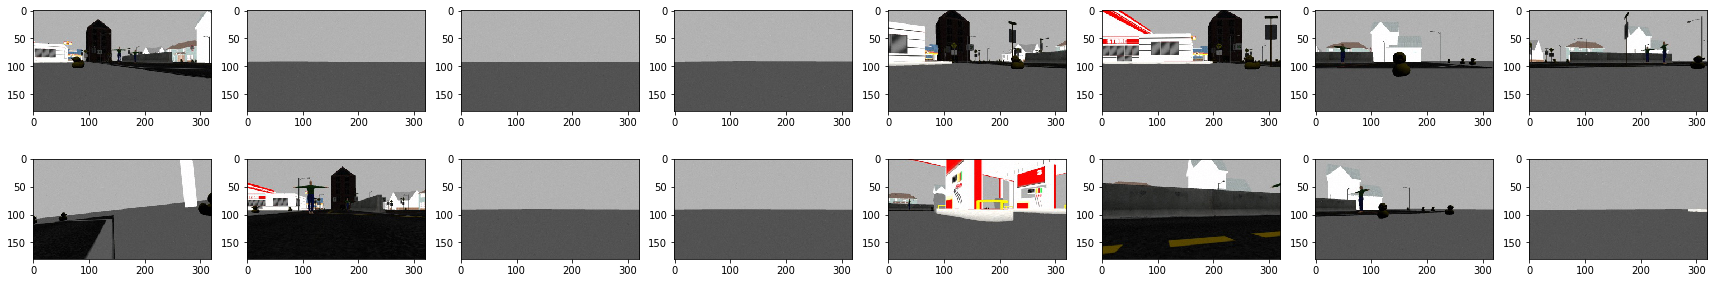

In [140]:
# Preview a batch

# Left Images
fig = plt.figure(figsize=(30,5))
for i in range(len(left_images)):
    fig.add_subplot(2, len(left_images)/2, i+1)
    plt.imshow(show_tensor_img(left_images[i]))

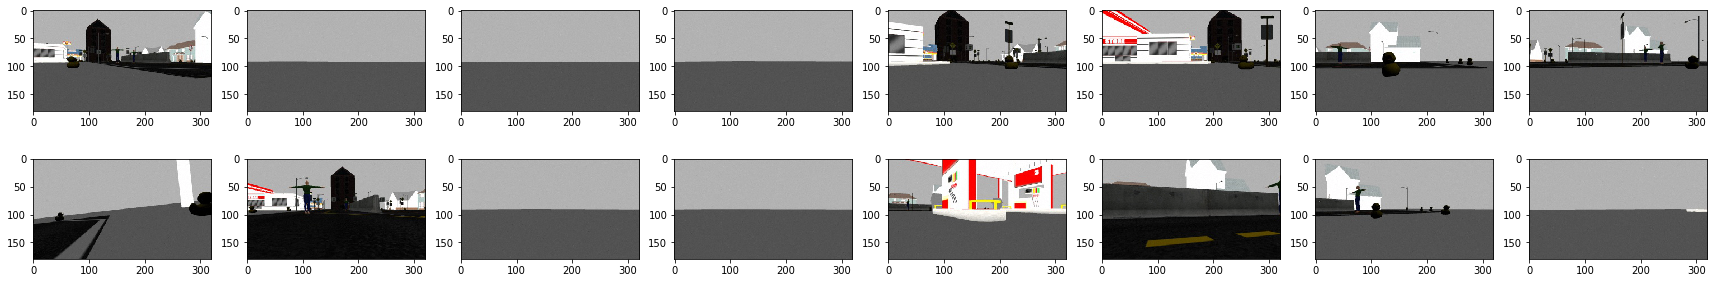

In [141]:
# Rigth Images
fig = plt.figure(figsize=(30,5))
for i in range(len(right_images)):
    fig.add_subplot(2, len(right_images)/2, i+1)
    plt.imshow(show_tensor_img(right_images[i]))

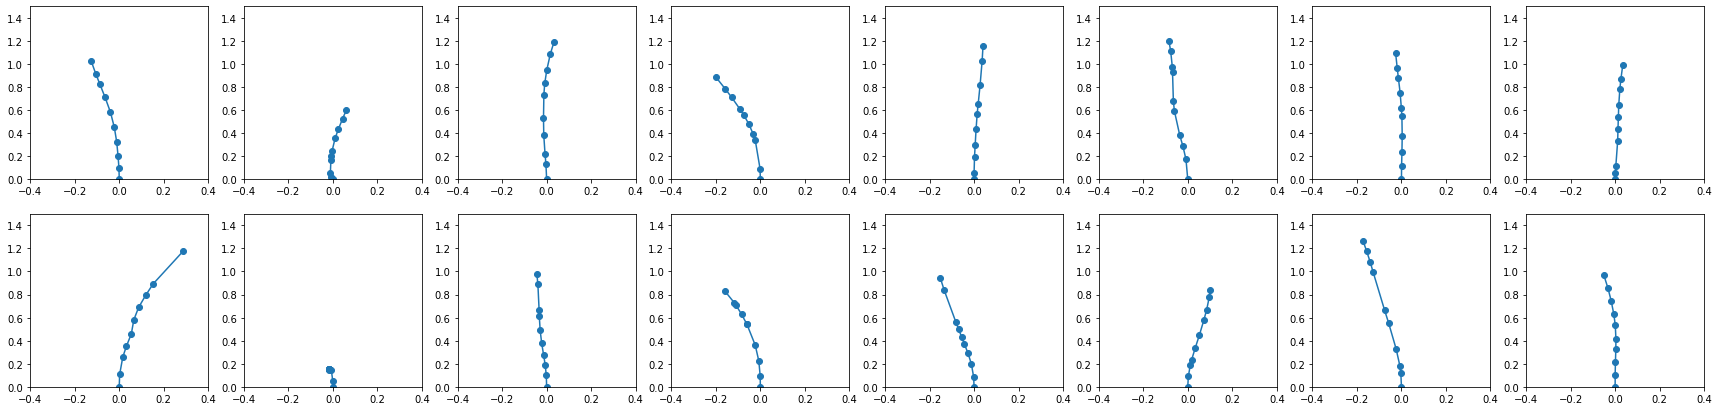

In [142]:
scale_factor_y = 1.5
scale_factor_x =0.4

fig = plt.figure(figsize=(30,7))
for i in range(len(labels)):
    fig.add_subplot(2, len(labels)/2, i+1)
    
    output_w_zero = labels[i].numpy().copy()[:,:2]
    positions_as_np = np.array(output_w_zero)
    
    plt.scatter(positions_as_np[:,0], positions_as_np[:,1])
    plt.plot(positions_as_np[:,0], positions_as_np[:,1])
    
    plt.xlim(-1 * scale_factor_x, 1 * scale_factor_x)
    plt.ylim(0 * scale_factor_y, 1 * scale_factor_y)
    
plt.show()

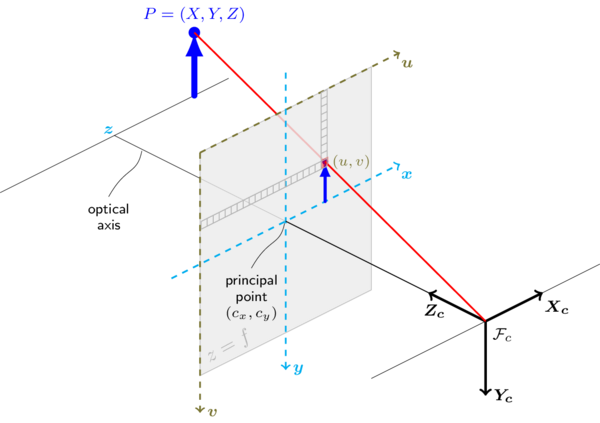

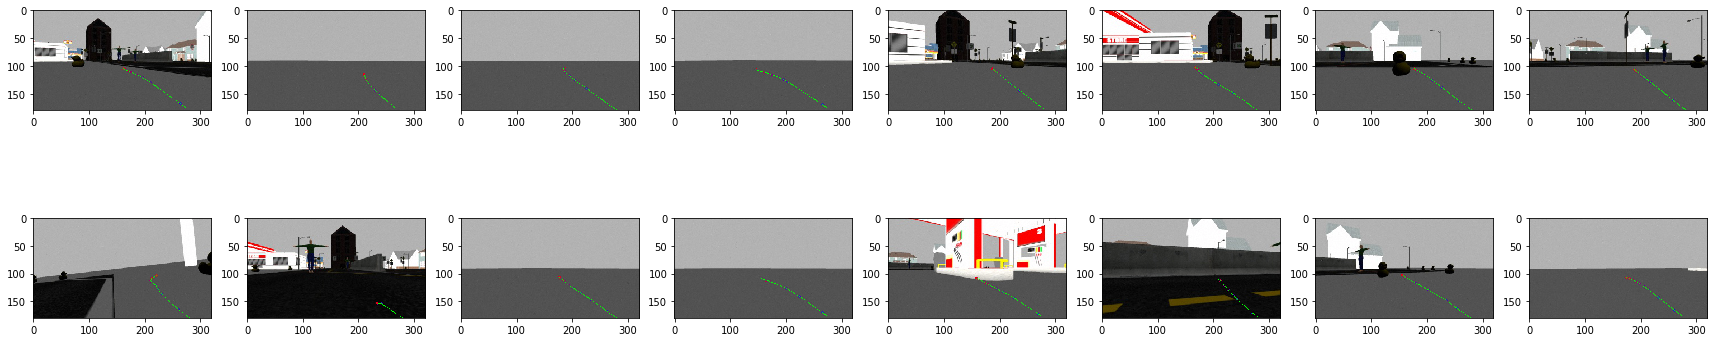

In [143]:
# Advanced visualization
import cv2
    
# camera matrix
cameraMatrix = np.float64([[190.68123344056778, 0.0, 160.5], [0.0, 190.68123344056778, 90.5], [0.0, 0.0, 1.0]]) # sim
# dist coefficients
distCoeffs = np.array([0.0, 0.0, 0.0, 0.0, 0.0]) # sim

# rotation/translaton of base_link - > camera optical link 
# 0.1485 0.1 0.1325 
# -0.5 0.5 -0.5 0.5
rvec = np.float64([-1.5707963, 1.5707963, 0 ])
tvec = np.float64([0.1485, 0.1, 0.1325])

# path to project onto image
fig = plt.figure(figsize=(30,7))
for p in range(len(labels)):
    fig.add_subplot(2, len(labels)/2, p+1)
    
    path = labels[p,:,:2].numpy().copy()
    camera_ref_path = np.zeros((len(path),3))
    for i, point in enumerate(path):
        # to coordinate system x = z, y = constant, z = x
        camera_ref_path[i] = ([point[0]+tvec[2], tvec[1], point[1]+tvec[0]])
    
    img = show_tensor_img(left_images[p]).copy()

    last_point = None
    for i, point in enumerate(camera_ref_path):
        reprojected_point = np.matmul(cameraMatrix, point)
        if(i == 0):
            cv2.circle(img, (int(reprojected_point[0]/reprojected_point[2]),int(reprojected_point[1]/reprojected_point[2])), 2, (0,1,0), 1)
            last_point = (int(reprojected_point[0]/reprojected_point[2]),int(reprojected_point[1]/reprojected_point[2]))
        else:
            cv2.circle(img, (int(reprojected_point[0]/reprojected_point[2]),int(reprojected_point[1]/reprojected_point[2])), 2, (i/len(camera_ref_path),0,1-i/len(camera_ref_path)), 1)
            cv2.line(img, last_point, (int(reprojected_point[0]/reprojected_point[2]),int(reprojected_point[1]/reprojected_point[2])), (0,1,0), 1)
            last_point = (int(reprojected_point[0]/reprojected_point[2]),int(reprojected_point[1]/reprojected_point[2]))

    plt.imshow(img)

## Construct the Model

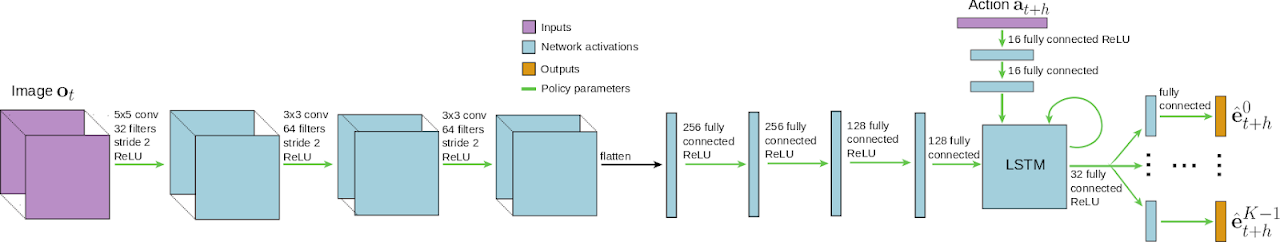

In [144]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# https://pytorch.org/docs/stable/nn.html
class NavNet(nn.Module):
    def __init__(self, input_shape=(3,180,320), hidden_dims=128, rnn_input_dims=32):
        super(NavNet, self).__init__()
                        
        # Constants for applying activations and loss functions only at specific locations in output tensor        
#         collision_mask = torch.tensor([0,0,0,1]).float()
#         self.register_buffer('collision_mask_const', collision_mask)
#         bumpiness_mask = torch.tensor([0,0,1,0]).float()
#         self.register_buffer('bumpiness_mask_const', bumpiness_mask)
#         position_mask = torch.tensor([1,1,0,0]).float()
#         self.register_buffer('position_mask_const', position_mask)
        
#         self.input_conv = nn.Sequential(
#             nn.Conv2d(3,32, kernel_size=5,stride=2, padding=0),
#             nn.ReLU(),
#             nn.Conv2d(32,32,5,2),
#             nn.ReLU(),
#             nn.Conv2d(32,64,3,2),
#             nn.ReLU(),
#             nn.Flatten()
#         )
        
#         fc_dims = self.input_conv(torch.zeros(input_shape).unsqueeze(0)).shape[1]
        
#         self.input_fc = nn.Sequential(
#             nn.Linear(fc_dims,hidden_dims*3),
#             nn.ReLU(),
#             nn.Linear(hidden_dims*3, hidden_dims*2),
#             nn.ReLU(),
#             nn.Linear(hidden_dims*2, hidden_dims),
#             nn.ReLU(),
#             nn.Linear(hidden_dims, hidden_dims)
#         )
                
        self.action_fc = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Linear(8, rnn_input_dims),
            nn.ReLU(),
            nn.Linear(rnn_input_dims, rnn_input_dims),
            nn.ReLU(),
            nn.Linear(rnn_input_dims, rnn_input_dims)
        )
        
        self.rnn = nn.GRU(rnn_input_dims, hidden_dims, 1, batch_first=True) # 16 input size, 128 hidden size

        
        self.output_fc = nn.Sequential(
            nn.Linear(hidden_dims, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 2) # x, y, collision, bumpiness
        )
        
    # seq is the action sequence to be evaluated [[action 1],[action 2],[action 3]]
    def forward(self,x,seq):
        
#         x = self.input_conv(x)
#         x = self.input_fc(x).unsqueeze(0)
                        
        actions = self.action_fc(seq)
                                
#         out, _ = self.rnn(actions, (x, x))
        out, _ = self.rnn(actions)
    
        output = self.output_fc(out)
        
        # apply sigmoid activation to collision probability
#         output = torch.sigmoid(output)*self.collision_mask_const + output*(self.bumpiness_mask_const + self.position_mask_const)
        
        return output
    
    # custom loss function https://github.com/gkahn13/badgr/blob/master/configs/bumpy_collision_position.py
    def navnet_loss(self, model_output, target): 

#         loss  = F.binary_cross_entropy(model_output*self.collision_mask_const, target*self.collision_mask_const)
#         loss += F.mse_loss(model_output*self.bumpiness_mask_const, target*self.bumpiness_mask_const)
#         loss = F.smooth_l1_loss(model_output*self.position_mask_const, target*self.position_mask_const)
#         loss = F.smooth_l1_loss(model_output, target[:,:,:2])
        loss = F.mse_loss(model_output, target[:,:,:2])

        return loss

PyTorch Version:  1.5.0
Torchvision Version:  0.6.0
cuda:0


In [145]:
import torchviz
navnet = NavNet()

In [146]:
test_batch_size = 5
action_seq_length = 6

test_input = torch.rand((test_batch_size, 3,180,320))
print("Input Image : ", test_input.shape)

test_actions = torch.rand((test_batch_size, action_seq_length,2))
print("Input Actions : ", test_actions.shape)

output = navnet(test_input, test_actions)
print("Output : ", output.shape)
print(output)

torchviz.make_dot(output).render("navnet", format="png")

Input Image :  torch.Size([5, 3, 180, 320])
Input Actions :  torch.Size([5, 6, 2])
Output :  torch.Size([5, 6, 2])
tensor([[[0.1057, 0.0187],
         [0.1051, 0.0179],
         [0.1049, 0.0176],
         [0.1047, 0.0173],
         [0.1046, 0.0172],
         [0.1045, 0.0171]],

        [[0.1056, 0.0187],
         [0.1051, 0.0179],
         [0.1049, 0.0176],
         [0.1047, 0.0173],
         [0.1046, 0.0173],
         [0.1045, 0.0171]],

        [[0.1056, 0.0185],
         [0.1052, 0.0179],
         [0.1049, 0.0176],
         [0.1048, 0.0173],
         [0.1046, 0.0172],
         [0.1046, 0.0170]],

        [[0.1057, 0.0186],
         [0.1051, 0.0179],
         [0.1048, 0.0175],
         [0.1046, 0.0173],
         [0.1046, 0.0172],
         [0.1045, 0.0171]],

        [[0.1057, 0.0187],
         [0.1052, 0.0179],
         [0.1049, 0.0175],
         [0.1047, 0.0173],
         [0.1046, 0.0172],
         [0.1045, 0.0171]]], grad_fn=<AddBackward0>)


'navnet.png'

## Training the model

In [147]:
from sklearn.metrics import accuracy_score

num_epochs = 30
steps_per_epoch = 50
batch_size = 16

hidden_dims = 128
timesteps = 7
collision_buffering = 3

train_generator = batch_generator(train_data, collision_buffering=collision_buffering, timesteps=timesteps, batch_size=batch_size, augmentation=False)
test_generator = batch_generator(validation_data, collision_buffering=collision_buffering, timesteps=timesteps, batch_size=batch_size, augmentation=False)

navnet = NavNet(input_shape=(3,180,320), hidden_dims=hidden_dims).to(device)
pytorch_total_params = sum(p.numel() for p in navnet.parameters())
print("Model Size: ", pytorch_total_params)

optimizer = optim.Adam(navnet.parameters(), lr=1e-4)
criterion = nn.MSELoss()

train_loss = []
train_collision_acc = []
train_bumpiness_error = []
train_position_error = []

valid_loss = []
valid_collision_acc = []
valid_bumpiness_error = []
valid_position_error = []

### MAKE SURE TO REMOVE WHEN USING THESE VARIABLES AGAIN
collision_acc = 0
bumpiness_error = 0

for e in range(num_epochs):
    # train
    avg_loss = 0
    avg_collision_acc = 0
    avg_bumpiness_error = 0
    avg_position_error = 0
    for s in range(steps_per_epoch):
        optimizer.zero_grad()

        left_images, right_images, actions, labels = next(train_generator)
                
        output = navnet(left_images.to(device), actions.to(device))
                
        loss = navnet.navnet_loss(output, labels.to(device))
#        loss = criterion(output, labels.to(device))
        
        loss.backward()
        optimizer.step()
        
#         collision_acc = accuracy_score(labels.cpu().numpy()[:,:,3], np.around(output.cpu().detach().numpy()[:,:,3]))
#         bumpiness_error = np.linalg.norm(labels.cpu().numpy()[:,:,1] - output.cpu().detach().numpy()[:,:,1])
        position_error = np.linalg.norm(labels.cpu().numpy()[:,:,:2] - output.cpu().detach().numpy()[:,:,:2])

        train_loss.append(loss.item())
        train_collision_acc.append(collision_acc)
        train_bumpiness_error.append(bumpiness_error)
        train_position_error.append(position_error)
        
        avg_loss += loss.item()
#         avg_collision_acc += collision_acc
#         avg_bumpiness_error += bumpiness_error
        avg_position_error += position_error
        
    avg_loss /= steps_per_epoch
#     avg_collision_acc /= steps_per_epoch
#     avg_bumpiness_error /= steps_per_epoch
    avg_position_error /= steps_per_epoch
        
        
    print('Training epoch: %d, loss: %.3f, collision acc: %.3f, bumpiness error: %.3f, position error: %.3f' % (e, avg_loss, avg_collision_acc, avg_bumpiness_error, avg_position_error))
    
    # validate
    avg_loss = 0
    avg_collision_acc = 0
    avg_bumpiness_error = 0
    avg_position_error = 0
    for s in range(steps_per_epoch):
        left_images, right_images, actions, labels = next(test_generator)
        output = navnet(left_images.to(device), actions.to(device))
        
        avg_loss += navnet.navnet_loss(output, labels.to(device)).item()
#         avg_collision_acc += accuracy_score(labels.cpu().numpy()[:,:,3], np.around(output.cpu().detach().numpy()[:,:,3]))
#         avg_bumpiness_error += np.linalg.norm(labels.cpu().numpy()[:,:,1] - output.cpu().detach().numpy()[:,:,1])
        avg_position_error += np.linalg.norm(labels.cpu().numpy()[:,:,:2] - output.cpu().detach().numpy()[:,:,:2])
        
    avg_loss /= steps_per_epoch
#     avg_collision_acc /= steps_per_epoch
#     avg_bumpiness_error /= steps_per_epoch
#     avg_position_error /= steps_per_epoch
        
    valid_loss.append(avg_loss)
#     valid_collision_acc.append(avg_collision_acc)
#     valid_bumpiness_error.append(avg_bumpiness_error)
#     valid_position_error.append(avg_position_error)
        
    print('Validating epoch: %d, loss: %.3f, collision acc: %.3f, bumpiness error: %.3f, position error: %.3f' % (e, avg_loss, avg_collision_acc, avg_bumpiness_error, avg_position_error))

    
print('Finished Training')

Model Size:  81338
Training epoch: 0, loss: 0.056, collision acc: 0.000, bumpiness error: 0.000, position error: 3.537
Validating epoch: 0, loss: 0.044, collision acc: 0.000, bumpiness error: 0.000, position error: 156.868
Training epoch: 1, loss: 0.036, collision acc: 0.000, bumpiness error: 0.000, position error: 2.792
Validating epoch: 1, loss: 0.018, collision acc: 0.000, bumpiness error: 0.000, position error: 100.652
Training epoch: 2, loss: 0.015, collision acc: 0.000, bumpiness error: 0.000, position error: 1.801
Validating epoch: 2, loss: 0.011, collision acc: 0.000, bumpiness error: 0.000, position error: 77.282
Training epoch: 3, loss: 0.011, collision acc: 0.000, bumpiness error: 0.000, position error: 1.551
Validating epoch: 3, loss: 0.010, collision acc: 0.000, bumpiness error: 0.000, position error: 72.963
Training epoch: 4, loss: 0.010, collision acc: 0.000, bumpiness error: 0.000, position error: 1.459
Validating epoch: 4, loss: 0.010, collision acc: 0.000, bumpiness e

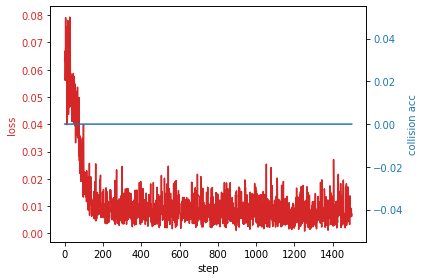

In [151]:
plot, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('step')
ax1.set_ylabel('loss', color=color)
ax1.plot(train_loss, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('collision acc', color=color)  # we already handled the x-label with ax1
ax2.plot(train_collision_acc, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plot.tight_layout()  # otherwise the right y-label is slightly clipped

Loss : collision acc : bumpiness l2 error : position l2 error


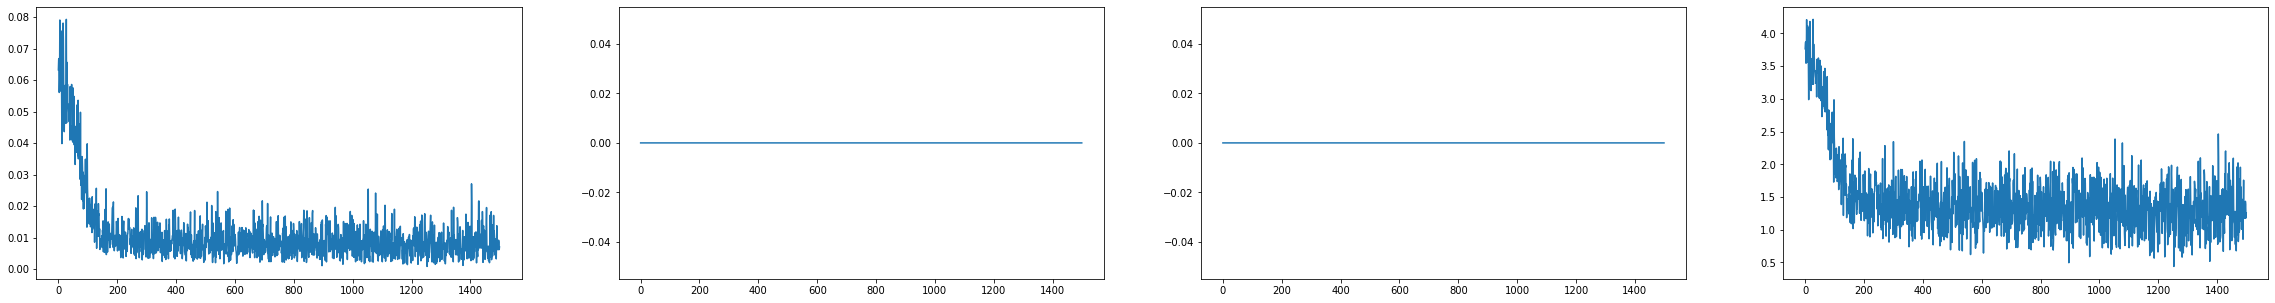

In [152]:
# Training Stats

fig = plt.figure(figsize=(40,5))
fig.add_subplot(1,4,1)
plt.plot(train_loss)
fig.add_subplot(1,4,2)
plt.plot(train_collision_acc)
fig.add_subplot(1,4,3)
plt.plot(train_bumpiness_error)
fig.add_subplot(1,4,4)
plt.plot(train_position_error)

print("Loss : collision acc : bumpiness l2 error : position l2 error")

Loss : collision acc : bumpiness l2 error : position l2 error


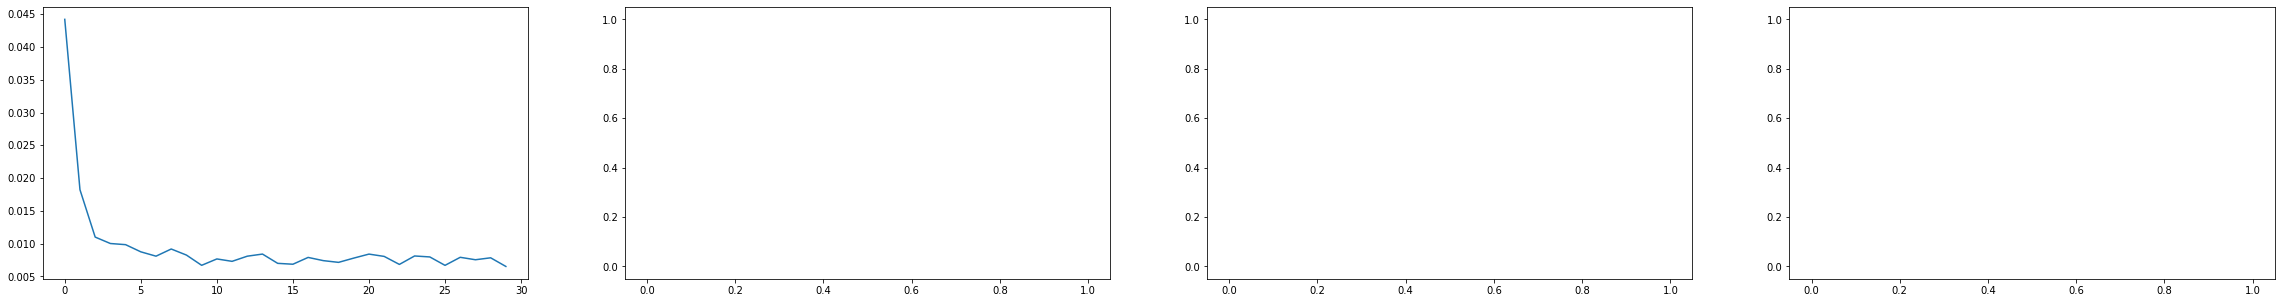

In [153]:
# Validation Stats

fig = plt.figure(figsize=(40,5))
fig.add_subplot(1,4,1)
plt.plot(valid_loss)
fig.add_subplot(1,4,2)
plt.plot(valid_collision_acc)
fig.add_subplot(1,4,3)
plt.plot(valid_bumpiness_error)
fig.add_subplot(1,4,4)
plt.plot(valid_position_error)

print("Loss : collision acc : bumpiness l2 error : position l2 error")

## Test the model

In [154]:
def visualize_output(image, actions, model_output, camera_matrix=np.float64([[190.68123344056778, 0.0, 160.5], [0.0, 190.68123344056778, 90.5], [0.0, 0.0, 1.0]]), 
                     tvec=np.float64([0.1485, 0.1, 0.1325]), rvec=np.float64([-1.5707963, 1.5707963, 0 ])):
    
    fig = plt.figure(figsize=(30,5))
    
    steps = model_output
    camera_ref_path = []
    for step in steps:
        # to coordinate system x = z, y = constant, z = x
        camera_ref_path.append([step[0].item()+tvec[2], tvec[1], step[1].item()+tvec[0]])
        
    img = show_tensor_img(image).copy()
    collisions = show_tensor_img(image).copy()
    bumpiness = show_tensor_img(image).copy()

    last_point = None
    for i, point in enumerate(camera_ref_path):
        reprojected_point = np.matmul(cameraMatrix, np.float64(point))
        if(i == 0):
            cv2.circle(img, (int(reprojected_point[0]/reprojected_point[2]),int(reprojected_point[1]/reprojected_point[2])), 2, (0,1,0), 1)
            cv2.circle(collisions, (int(reprojected_point[0]/reprojected_point[2]),int(reprojected_point[1]/reprojected_point[2])), 2, (0,1,0), 1)
            cv2.circle(bumpiness, (int(reprojected_point[0]/reprojected_point[2]),int(reprojected_point[1]/reprojected_point[2])), 2, (0,1,0), 1)
            last_point = (int(reprojected_point[0]/reprojected_point[2]),int(reprojected_point[1]/reprojected_point[2]))
        else:
            new_point = (int(reprojected_point[0]/reprojected_point[2]),int(reprojected_point[1]/reprojected_point[2]))
            
            cv2.circle(img, new_point, 2, (i/len(camera_ref_path),0,1-i/len(camera_ref_path)), 1)
            cv2.line(img, last_point, new_point, (0,1,0), 1)
            
#             cv2.circle(collisions, new_point, 2, (min(max(model_output[i][3].item(),0),1),0,1-min(max(model_output[i][3].item(),0),1)), 1)
#             cv2.line(collisions, last_point, new_point, (0,1,0), 1)
            
#             cv2.circle(bumpiness, new_point, 2, (min(max(model_output[i][2].item()*20,0),1),0,1-min(max(model_output[i][2].item()*20,0),1)), 1)
#             cv2.line(bumpiness, last_point, new_point, (0,1,0), 1)
            
            last_point = new_point
    
    print("Path plot : Path plot on image : Collision : Bumpiness : Steering")

    model_output_npy = model_output.cpu().detach().numpy()
    
    fig.add_subplot(1, 5, 1)
    plt.scatter(model_output_npy[:,0], model_output_npy[:,1])
    plt.plot(model_output_npy[:,0], model_output_npy[:,1])
    
    plt.xlim(-1 * scale_factor_x, 1 * scale_factor_x)
    plt.ylim(0 * scale_factor_y, 1 * scale_factor_y)
    
    fig.add_subplot(1, 5, 2)
    plt.imshow(img)
    
    fig.add_subplot(1, 5, 3)
    plt.imshow(collisions)
    
    fig.add_subplot(1, 5, 4)
    plt.imshow(bumpiness)
    
    fig.add_subplot(1, 5, 5)
    plt.bar(np.arange(len(actions)), np.array(actions)[:,1])

In [155]:
def label_to_output(label, index):
    return torch.cat((torch.tensor(label[2][index], dtype=torch.float32).unsqueeze(1),torch.tensor(label[1][index]).unsqueeze(1),torch.tensor(label[0][index])), axis=1)

### Eval model

In [156]:
test_generator = batch_generator(train_data, collision_buffering=collision_buffering, timesteps=timesteps, batch_size=16, augmentation=False)
left_image, right_image, actions, labels = next(train_generator)

print("Input image size : ", left_image.shape)
print("Input actions size : ", actions.shape)

Input image size :  torch.Size([16, 3, 180, 320])
Input actions size :  torch.Size([16, 7, 2])


Path plot : Path plot on image : Collision : Bumpiness : Steering


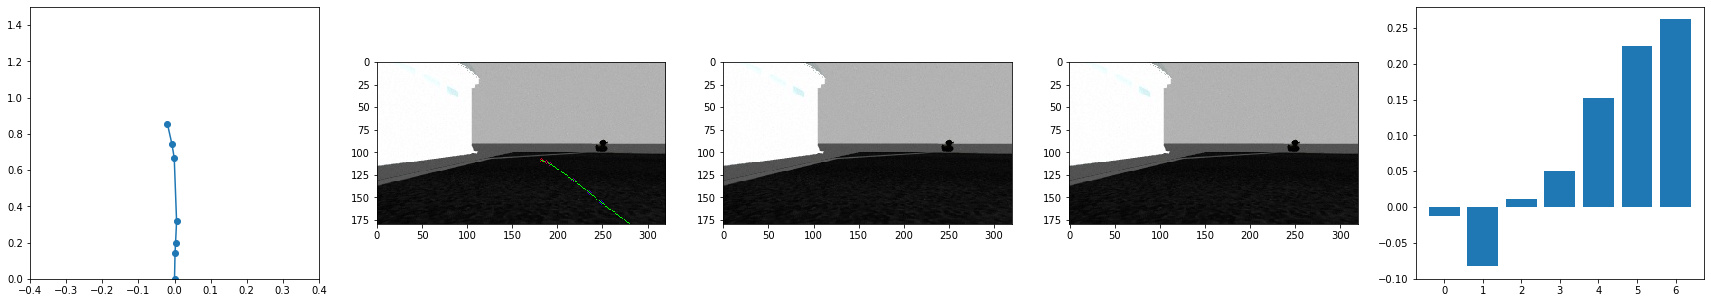

In [157]:
test_index = 11
visualize_output(left_image[test_index], actions[test_index], labels[test_index])

torch.Size([16, 7, 2])
Path plot : Path plot on image : Collision : Bumpiness : Steering


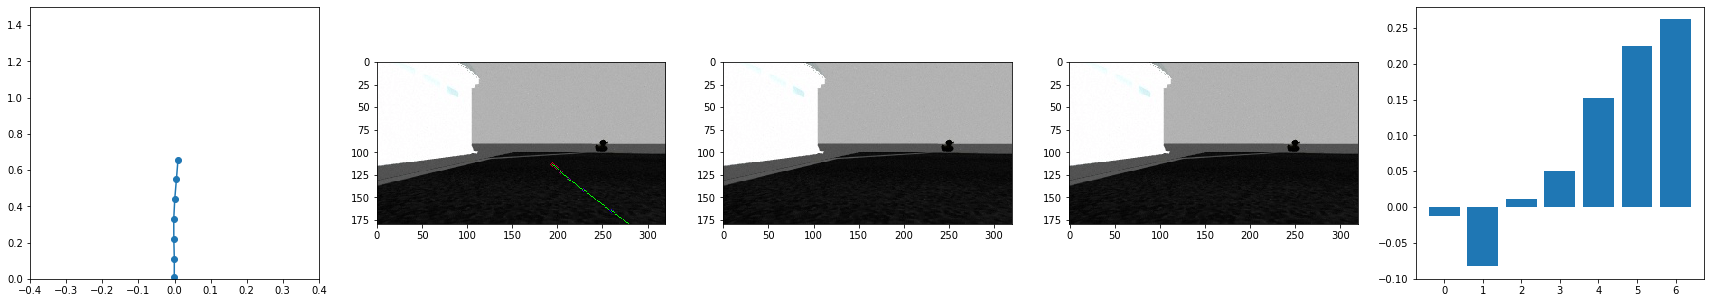

In [158]:
navnet.eval().to(device)

output = navnet(left_image.to(device)
                , actions.to(device))
print(output.shape)
visualize_output(left_image[test_index], actions[test_index], output[test_index])

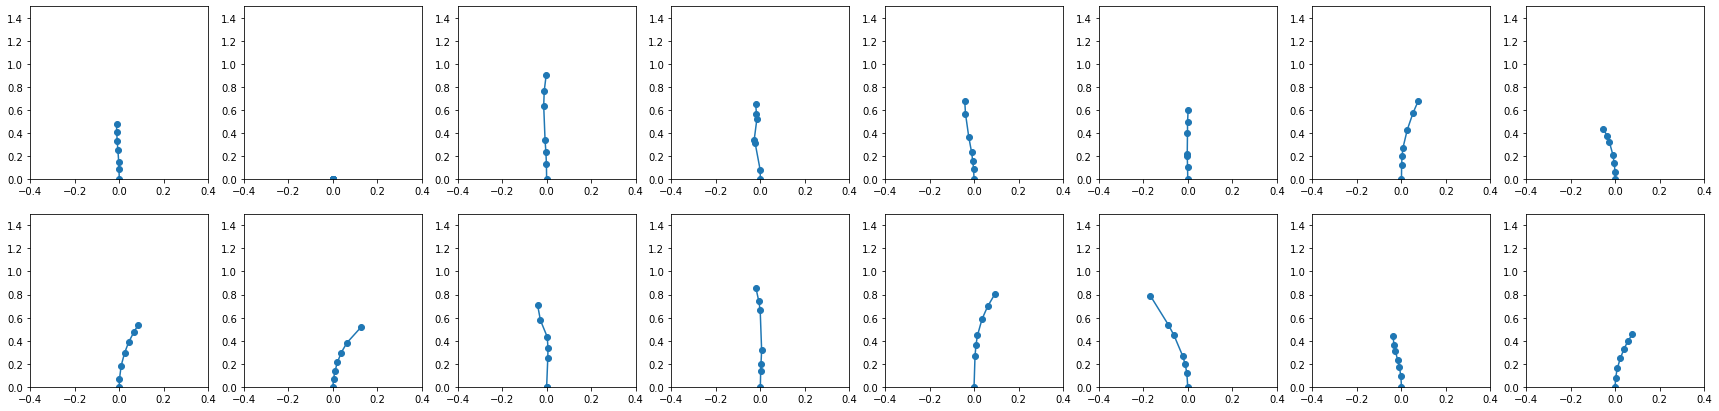

In [161]:
scale_factor_y = 1.5
scale_factor_x =0.4

fig = plt.figure(figsize=(30,7))
for i in range(len(labels)):
    fig.add_subplot(2, len(labels)/2, i+1)
    
    output_w_zero = labels[i].numpy().copy()[:,:2]
    positions_as_np = np.array(output_w_zero)
    
    plt.scatter(positions_as_np[:,0], positions_as_np[:,1])
    plt.plot(positions_as_np[:,0], positions_as_np[:,1])
    
        
    plt.xlim(-1 * scale_factor_x, 1 * scale_factor_x)
    plt.ylim(0 * scale_factor_y, 1 * scale_factor_y)
    
plt.show()

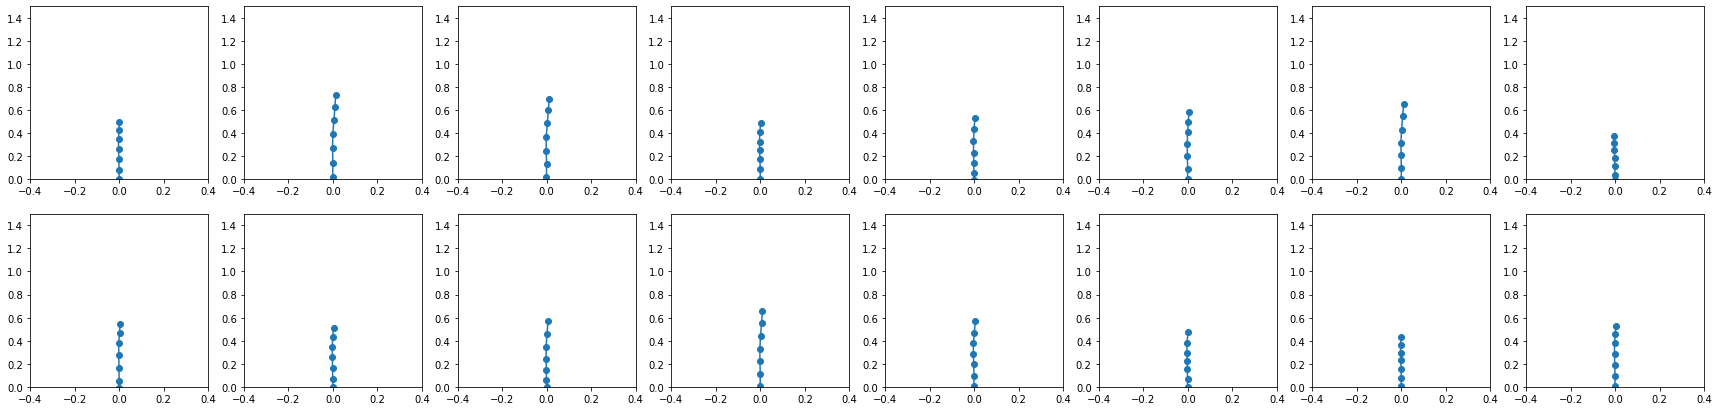

In [162]:
fig = plt.figure(figsize=(30,7))
for i in range(len(output)):
    fig.add_subplot(2, len(output)/2, i+1)
        
    output_w_zero = output[i].cpu().detach().numpy().copy()[:,:2]
    positions_as_np = np.array(output_w_zero)
    
    plt.scatter(positions_as_np[:,0], positions_as_np[:,1])
    plt.plot(positions_as_np[:,0], positions_as_np[:,1])
        
    plt.xlim(-1 * scale_factor_x, 1 * scale_factor_x)
    plt.ylim(0 * scale_factor_y, 1 * scale_factor_y)
    
plt.show()

## Save the Model

In [30]:
# Standard pytorch model saving/loading
name = "navnet-6-8-20"
torch.save(navnet.state_dict(), name + ".pt")
navnet.load_state_dict(torch.load(name + ".pt")) # test reloading model

<All keys matched successfully>

In [31]:
# Saving as pytorch jit for C++

example_image = torch.rand(1, 3, 180, 320)
exmaple_actions = torch.rand(1, 50, 2)

example_input = (example_image.to(device), exmaple_actions.to(device))

# Use torch.jit.trace to generate a torch.jit.ScriptModule via tracing.
traced_script_module = torch.jit.trace(navnet.to(device).eval(), example_input) # .eval() changes behavior of the batch norm layer so as not to require larger than 1 batch size
traced_script_module.save(name + "-traced.pt")

## TRTorch (not working yet)

In [479]:
import trtorch

torch_script_module = torch.jit.load('navnet-5-1-20-traced.pt')

compile_settings = {"input_shapes" : [[1, 3, 180, 320], [1,49,2]]}

trt_ts_module = trtorch.compile(torch_script_module, compile_settings)

# input_data = input_data.half()
result = trt_ts_module(example_input)

ModuleNotFoundError: No module named 'trtorch'